# ニューラルネットワークの学習

訓練データから最適な重みパラメータの値を自動で獲得することを目指す

## 損失関数

### 2 乗和誤差

$$ E = \frac{1}{2} \sum_{k} (y_k - t_k)^2 $$

In [3]:
import numpy as np
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

In [6]:
# index:2 を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(t), np.array(y))

0.097500000000000031

In [7]:
# index:7 を正解とする
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(t), np.array(y))

0.59750000000000003

### 交差エントロピー誤差

$$ E = -\sum_{k} t_k \log{y_k} $$

In [8]:
def cross_entropy_error(y, t):
    delta = 1e-7 # log(0) でエラーになるのを防止するために、小さな値と足し合わせて log る
    return -np.sum(t * np.log(y + delta))

In [12]:
# index:2 を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.51082545709933802

In [11]:
# index:7 を正解とする
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.3025840929945458

### ミニバッチ学習

訓練データすべての損失関数の和をもとめたい

$$ E = - \frac{1}{N} \sum_{n} \sum_{k} {t_{n\ k} \log{y_{n\ k}}} $$

単純に交差エントロピー誤差を N 個分足し合わせた後、N で割って正規化を行う

In [31]:
from sklearn.datasets import fetch_mldata
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline
mnist = fetch_mldata('MNIST original')

In [32]:
train_size = mnist.data.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = mnist.data[batch_mask]
t_batch = mnist.target[batch_mask]

In [33]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    plt.imshow(np.array(pil_img))

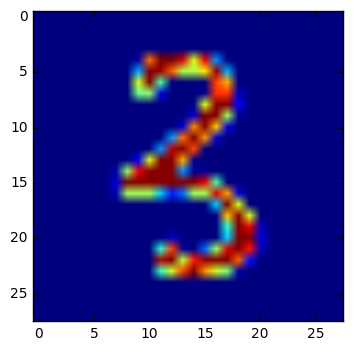

In [39]:
# img_show(x_batch[1].reshape(28, 28))
img_show(x_batch[9].reshape(28, 28))

In [23]:
# バッチ対応版の交差エントロピー誤差の実装
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [ ]:
cross_en